In [1]:
!pip install timm torchsummary tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from math import ceil
from time import time
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam, SGD
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [3]:
np.random.seed(42)
torch.manual_seed(42)

## Setting up the GPU/CPU
will depend on the selected runtime for colab

In [4]:
torch.cuda.current_device()

0

In [5]:
torch.cuda.device(0)

In [6]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

## Code to edit the csv with correct image_file paths

In [8]:
original_image_path = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/1.training/1.training'
reflect101_img_path = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/std_shape/data_border_reflect_101/1.training'
constant_image_path = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/std_shape/data_border_constant/1.training'

In [9]:
# creating a 2d list where the first list contains path of images
# the second list contains a flag denoting whether the image is from original set or bordered
# and the third list contains one-hot encoded label vectors
image_path_list = []

In [10]:
def img_list(data_path):
  # getting list of all the images
  images = os.listdir(data_path)
  exc_list = ['[1, 1, 0]', '[1, 0, 1]', '[0, 1, 1]', '[1, 1, 1]']
  # setting the flag based on the image path
  '''
  if path == orig_image_path:
    flag = 0
  else:
    flag = 1
  '''
  # don't need the flag, just resize all the images while loading to (224, 224)

  # adding to the image_path_list
  for i in images:
    # adding the image path, flag and the label
    #image_path_list[0].append([path + '/' + str(i), flag, list(map(int, i[-13:-4].strip('][').split(', ')))])
    
    if i[-13:-4] not in exc_list:
      # adding the image path, and the label
      image_path_list.append([data_path + '/' + str(i), list(map(int, i[-13:-4].strip('][').split(', ')))])
    else:
      continue

In [11]:
# loading image paths from original dataset
img_list(original_image_path)

# loading image paths from constant bordered dataset
img_list(constant_image_path)

# loading image paths from reflect_101 bordered dataset
img_list(reflect101_img_path)

In [12]:
len(image_path_list)

14079

In [13]:
train_list, test_list = train_test_split(image_path_list, test_size = 0.2, train_size = 0.8)

In [14]:
len(train_list)

11263

In [15]:
len(test_list)

2816

## Creating the dataset class

In [16]:
# Creating the dataset class for the data

class LUAD(Dataset):
  """Lung Adenocarcinoma Histopathological images."""
  
  def __init__(self, image_list, transform = None):
    
    """
      Args:
        image_list: csv/list/numpy array containing image paths, flag and labels.
        transform (callable, optional): Optional transform to be applied on a sample.
        """
    #Loading the csv file containing the image paths and one-hot encoded labels
    #self.image_paths_labels = pd.read_csv(csv_file)
    self.image_list = image_list
    self.transform = transform

  def __len__(self):
    return len(self.image_list)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    # code when input is a csv file
    '''
    image = cv2.imread(image_paths_labels.iloc[idx, 0])
    image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W) do this in transforms
    labels = self.image_paths_labels.iloc[idx, 1]
    labels = np.array([labels])
    labels = labels.astype('int').reshape(-1, 3)        # check what exactly to do with this
    sample = {'image': image, 'labels': labels}
    '''
    #print(idx) keeps printing 
    # code when the input is a list of image paths and labels
    image = cv2.imread(self.image_list[idx][0])
    #image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W)
    labels = self.image_list[idx][1]
    labels = np.array([labels])
    #labels = labels.astype('int').reshape(-1, 3) #.argmax(axis=1)        # reshapes the labels array into (n, 3) array
    labels = labels.astype('int').reshape(-1)
    #sample = {'image': image, 'labels': labels}
    
    if self.transform:
      #sample = self.transform(sample)
      image = self.transform(image)
    
    return image, labels

2816
0 (224, 224, 3) (3,)
1 (224, 224, 3) (3,)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


2 (224, 224, 3) (3,)
3 (250, 205, 3) (3,)


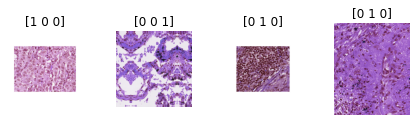

In [17]:
# check if the dataloader works
check_loader = LUAD(image_list=test_list)

print(len(check_loader))
fig = plt.figure()

for i in range(len(check_loader)):
    #sample = check_loader[i]
    image, labels = check_loader[i]

    print(i, image.shape, labels.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    #ax.set_title(sample['labels'])
    ax.set_title(labels)
    ax.axis('off')
    #plt.imshow(sample['image'])
    plt.imshow(image)

    if i == 3:
        plt.show()
        break

type(check_loader[1][1])

check_loader[1][1].shape

In [18]:
# creatin the train dataset
train_dataset = LUAD(train_list,
                     transform = transforms.Compose([transforms.ToTensor(),
                                                     transforms.Resize((224, 224)),
                                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),]
                                                     ))

# creating the test dataset
test_dataset = LUAD(test_list,
                    transform = transforms.Compose([transforms.ToTensor(),
                                                    transforms.Resize((224, 224)),
                                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),]
                                                    ))

In [19]:
batch_size = 64  #128

In [20]:
# train dataloader
train_dataloader = DataLoader(train_dataset,
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers = 2,
                              )

# test dataloader
test_dataloader = DataLoader(test_dataset,
                             batch_size = batch_size,
                             shuffle = True,
                             num_workers = 2,
                             )

In [21]:
len(train_dataloader)

176

In [22]:
model_vit_base_patch16_224 = timm.create_model('vit_base_patch16_224', pretrained = True, num_classes = 3,
                                               drop_rate = 0.2, attn_drop_rate = 0.2).to(device)
#print(model(torch.randn(1, 3, 224, 224)))

In [23]:
torchsummary.summary(model_vit_base_patch16_224, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
         LayerNorm-5             [-1, 197, 768]           1,536
            Linear-6            [-1, 197, 2304]       1,771,776
           Dropout-7         [-1, 12, 197, 197]               0
            Linear-8             [-1, 197, 768]         590,592
           Dropout-9             [-1, 197, 768]               0
        Attention-10             [-1, 197, 768]               0
         Identity-11             [-1, 197, 768]               0
        LayerNorm-12             [-1, 197, 768]           1,536
           Linear-13            [-1, 197, 3072]       2,362,368
             GELU-14            [-1, 19

### Checking model properties

In [24]:
next(model_vit_base_patch16_224.parameters()).is_cuda

True

In [25]:
y_pred = model_vit_base_patch16_224(torch.randn(2, 3, 224, 224).to(device))
y_pred

tensor([[-1.0853,  1.0630,  1.9651],
        [ 0.7079,  0.3126,  1.1017]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [26]:
y_pred.argmax(axis=1)

tensor([2, 2], device='cuda:0')

In [27]:
y_p = nn.functional.softmax(y_pred, dim=-1)
y_p

tensor([[0.0326, 0.2792, 0.6882],
        [0.3168, 0.2134, 0.4698]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [28]:
y_p.argmax(axis=1)

tensor([2, 2], device='cuda:0')

y_pred

y_pred.shape

type(y_pred)

y_pred.argmax(axis=1)

y = np.array([[0, 1, 0], [1, 0, 1]])

torch.from_numpy(y)

y.shape

nn.CrossEntropyLoss()(y_pred, torch.from_numpy(y.argmax(axis=1)))

for i_batch, (x, y) in enumerate(test_dataloader):
  print(x.shape, y.shape)
  print(len(y.argmax(axis=1)))
  model_vit_base_patch16_224(x.to(device))

  if i_batch == 0:
    break

model_vit_base_patch16_224(torch.randn(32, 3, 224, 224)).shape

## Training and validation

In [29]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               opt: torch.optim.Optimizer,
               eval_fn = accuracy_score,
               device: torch.device = device
               ):
  
  train_loss, train_acc = 0, 0
  model.train()
  for batch, (x, y) in enumerate(data_loader):
    
    print(f'batch: {batch}')
    #x = data['image']
    #y = data['labels']
    # send data to GPU
    x, y = x.to(device), y.to(device)

    #clear gradients
    opt.zero_grad()

    # forward pass
    y_pred = nn.functional.softmax(model(x), dim = -1)

    # calculate loss
    loss = loss_fn(y_pred, y.argmax(axis=1))
    #print(loss) Printed the loss per batch per epoch
    train_loss += loss
    train_acc += eval_fn(y.cpu().argmax(axis=1), y_pred.cpu().detach().numpy().argmax(axis=1))

    # back-prop
    loss.backward()

    # optimize
    opt.step()

  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}")

In [30]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              eval_fn = accuracy_score,
              device: torch.device = device
              ):
  test_loss, test_acc = 0, 0
  model.eval() # put model in eval mode
  
  # Turn on inference context manager
  with torch.inference_mode(): 
    for (X, y) in data_loader:

      #x = data['image']
      #y = data['labels']
      
      # Send data to GPU
      X, y = X.to(device), y.to(device)
      
      # 1. Forward pass
      test_pred = nn.functional.softmax(model(X), dim = -1)
      
      # 2. Calculate loss and accuracy
      test_loss += loss_fn(test_pred, y.argmax(axis=1))
      test_acc += eval_fn(y.cpu().argmax(axis=1), test_pred.cpu().detach().numpy().argmax(axis=1))
      
    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}\n")
    return test_loss, test_acc

In [31]:
model_save_path = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Models/model_vit_base_patch16_224_1.pth'

In [32]:
epochs = 50

In [33]:
valid_acc = -np.inf

for epoch in tqdm(range(epochs)):

  print(f"Epoch: {epoch}\n---------")
  train_step(data_loader=train_dataloader,
             model=model_vit_base_patch16_224,
             loss_fn=nn.CrossEntropyLoss(),
             #opt=SGD(model_vit_base_patch16_224.parameters(), lr=0.00001),
             opt=Adam(model_vit_base_patch16_224.parameters(), lr=0.00001),
             eval_fn=accuracy_score
             )
  
  # validation named as test step
  ep_v_loss, ep_v_acc = test_step(data_loader=test_dataloader,
                                  model=model_vit_base_patch16_224,
                                  loss_fn=nn.CrossEntropyLoss(),
                                  eval_fn=accuracy_score
                                  )
  
  if ep_v_acc > valid_acc:
    print(f"accuracy increased from {valid_acc} to {ep_v_acc} saving model to: {model_save_path}")
    torch.save(obj = model_vit_base_patch16_224.state_dict(),
               f = model_save_path)
    valid_acc = ep_v_acc

  0%|          | 0/50 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
batch: 67
batch: 68
batch: 69
batch: 70
batch: 71
batch: 72
batch: 73
batch: 74
batch: 75
batch: 76
batch: 77
batch: 78
batch: 79
batch: 80
batch: 81
batch: 82
batch: 83
batch: 84
batch: 85
batch: 86
batch: 87
batch: 88
batch: 89
batch: 90
batch: 91
batch: 92
batch: 93
batch: 94
batch: 95
batch: 96
batch: 97
batch: 98
batch: 99
batch: 100
batch: 101
batch: 102
batch: 103
batch: 104
batch: 105
batch: 106
batch: 107
batch: 108
batch: 109
batch: 110
batch: 111
batch: 112
batch: 113
batch: 114
batch: 115
batch: 116
batch: 117
batch: 118
batch: 119
batch: 120
batch: 121
batch: 122
batch: 123
batch: 124
batch: 125
batch: 126
batch: 127
batch: 128
batch: 129
batch: 130
batch: 131
batch: 132
batch: 133
batch: 134
batch: 135
batch: 136
batch: 137
batch: 138
batch: 139
batch: 140
batch: 141
batch: 142
batch: 143
batch: 144
batch: 145
batch: 146
batch: 147
batch: 148
batch: 149
batch: 150
batch: 151
batch: 152
batch: 153
batch: 154
batch: 155
bat